In [12]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
import sklearn
import glob
import pickle
import numpy as np
import copy
import random
import os
import pandas as pd
import re
import timeit

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import f1_score
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split

from sklearn.model_selection import GridSearchCV 


from sklearn import model_selection

from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS

from nltk import sent_tokenize

from sklearn.model_selection import train_test_split

from sklearn.model_selection import cross_val_score

from helpers import LemmaTokenizer, StemTokenizer, SnowballStemTokenizer, misc_features, cleaner, get_tfidf_vectorizer

import matplotlib.pyplot as plt

In [14]:
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (20, 10)

### loading files

In [3]:
try:
    cwd = os.path.dirname(os.path.abspath(__file__))
except:
    cwd = os.getcwd()

In [4]:
train_filepath = os.path.join(cwd, "data", "train.csv")

In [41]:
train_perc = 0.8

train_df = pd.read_csv(train_filepath)
X_df = train_df.drop(columns=['is_duplicate'])
Y_df = train_df['is_duplicate']

X_train, X_test, y_train, y_test =  train_test_split(X_df, Y_df, test_size=0.2, random_state=42)

In [43]:
X_train.head(5)

,id,qid1,qid2,question1,question2
352886,352886,214777,481858,What are some of the short stories?,What are some great short stories with a twist...
134949,134949,178460,215604,Is this a German Shepherd dog?,Are german shepherd dogs loyal?
168419,168419,74366,106454,What is the most important lesson ever learned...,What are the most important lessons you have l...
402543,402543,257727,111990,Which ad networks for mobile native ads have a...,Which ad networks for desktop native ads have ...
13551,13551,26006,26007,What should I do to be an athlete in a month?,What is shop act licence?


In [14]:
# combining the strings together

### some basic stats

In [69]:
question_ids = pd.Series(X_train['qid1'].tolist() + X_train['qid2'].tolist())

print('total questions: {}'.format(len(X_train)))
print('duplicates: {}%'.format(y_train.values.mean()*100, 2))
print('total questions : {}'.format(len(set(question_ids))))
print('questions with multiple occurences: {}'.format(np.sum(question_ids.value_counts() > 1)))

total questions: 323432
duplicates: 36.857206460708895%
total questions : 449983
questions with multiple occurences: 86047


In [70]:
# checking the amount of duplicates and non duplicates

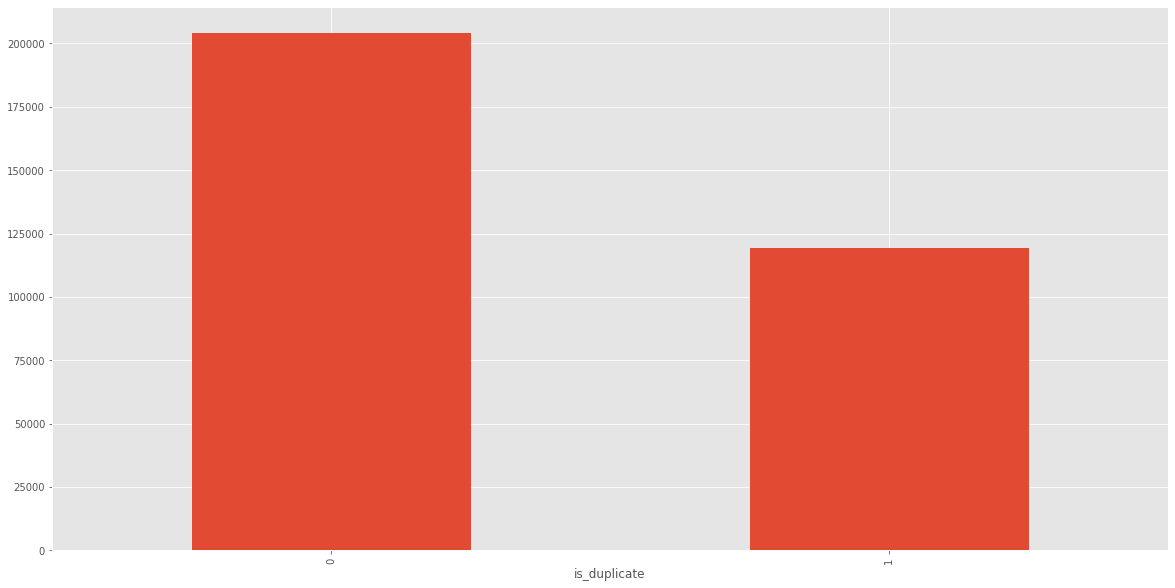

In [71]:
train_df.loc[X_train.index].groupby("is_duplicate")['id'].count().plot(kind='bar')

In [72]:
# loking at questions that appear multiple times and their distribution

(0, 10)

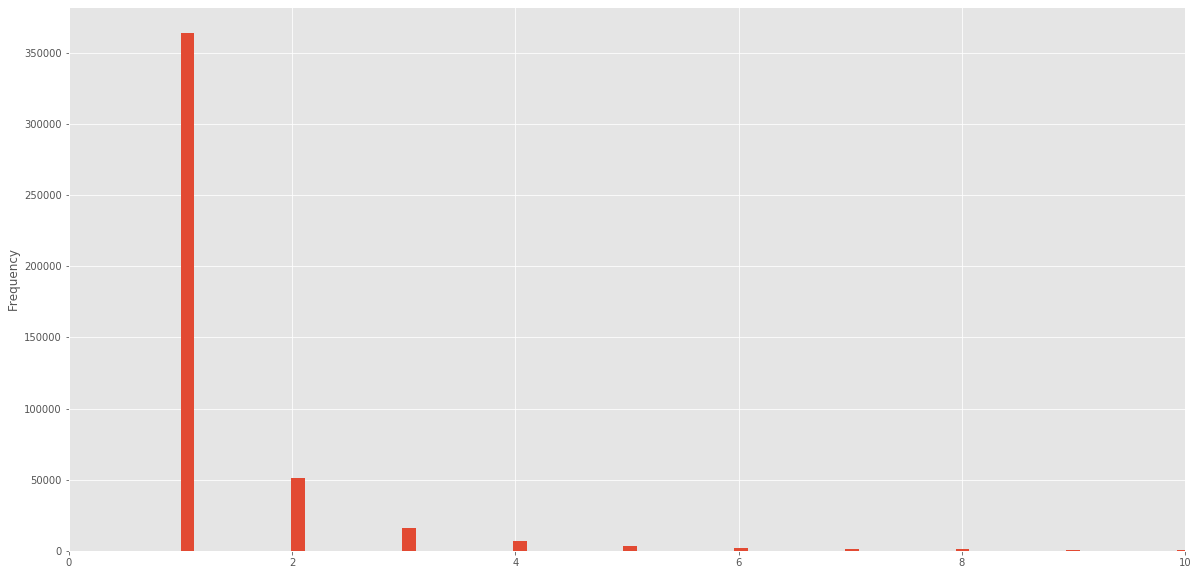

In [73]:
plt.figure()
question_ids.value_counts().plot(kind='hist', bins=1000)
plt.xlim(0, 10)

mostly appear very few times, good.

In [35]:
# word count distribution

In [83]:
question_cat = pd.Series(X_train['question1'].tolist() + X_train['question2'].tolist())

No handles with labels found to put in legend.


mean: 11.065537732815553; std 5.888389777969719; max 237


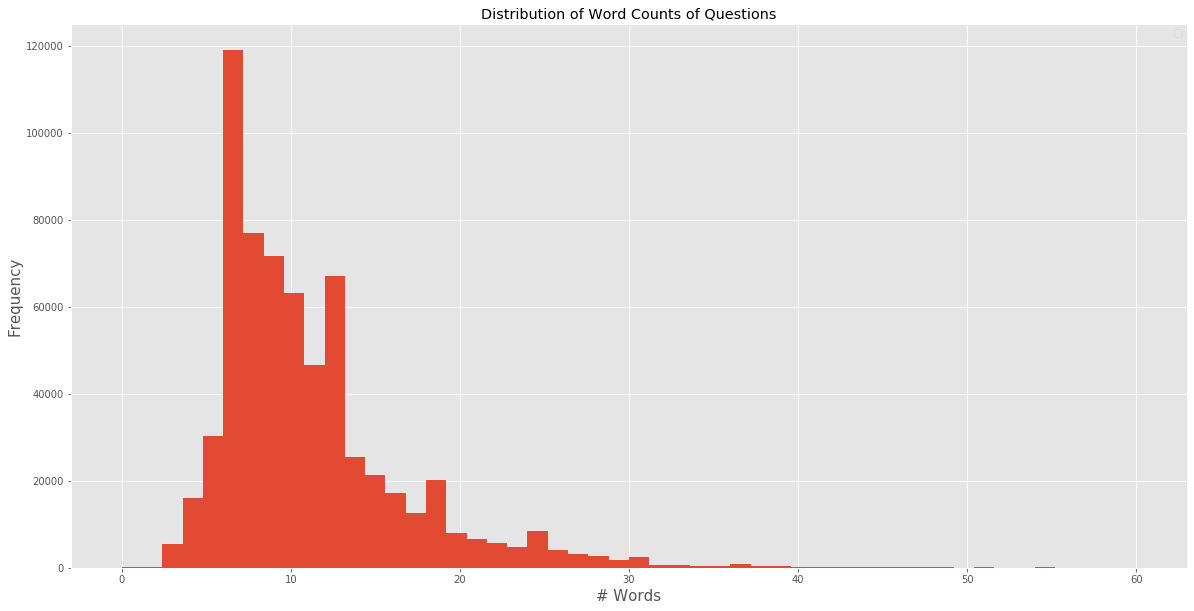

In [92]:
word_spread = question_cat.apply(lambda x: len(x.split(' ')))

plt.figure()
plt.hist(word_spread, bins=50, range=[0, 60])
plt.title('Distribution of Word Counts of Questions')
plt.legend()
plt.xlabel('# Words', fontsize=15)
plt.ylabel('Frequency', fontsize=15)

print('mean: {}; std {}; max {}'.format(word_spread.mean(), word_spread.std(), word_spread.max()))

In [91]:
word_spread.describe()

count    646864.000000
mean         11.065538
std           5.888390
min           1.000000
25%           7.000000
50%          10.000000
75%          13.000000
max         237.000000
dtype: float64

Looks like most questions fall between 7 to 13 words.

### word overlaps

In [153]:
stop_words = set(stopwords.words("english"))

def get_word_diffs(questions):
    q1_list = str(questions['question1']).lower().split()
    q2_list = str(questions['question2']).lower().split()
    
    q1_list = [word for word in q1_list if word not in stop_words]
    q2_list = [word for word in q2_list if word not in stop_words]
    
    diff = abs(len(q1_list) - len(q2_list))
    
    return diff

def get_word_overlaps(questions):
#     print(questions)
    q1_list = str(questions['question1']).lower().split()
    q2_list = str(questions['question2']).lower().split()
    
    q1_list = [word for word in q1_list if word not in stop_words]
    q2_list = [word for word in q2_list if word not in stop_words]
    
    q1_set = set(q1_list)
    q2_set = set(q2_list)
    q12_set = set(q1_list + q2_list)
    
    overlap_count = q1_set.intersection(q2_set)
    overlap_perc = float(len(overlap_count)) / len(q12_set)
    
    return overlap_perc

In [154]:
word_overlaps = train_df.loc[X_train.index].apply(get_word_overlaps, axis=1)

In [160]:
word_diffs = train_df.loc[X_train.index].apply(get_word_diffs, axis=1)

/Users/nahiyanmalik/anaconda/envs/mlp3/lib/python3.6/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  
/Users/nahiyanmalik/anaconda/envs/mlp3/lib/python3.6/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  This is separate from the ipykernel package so we can avoid doing imports until


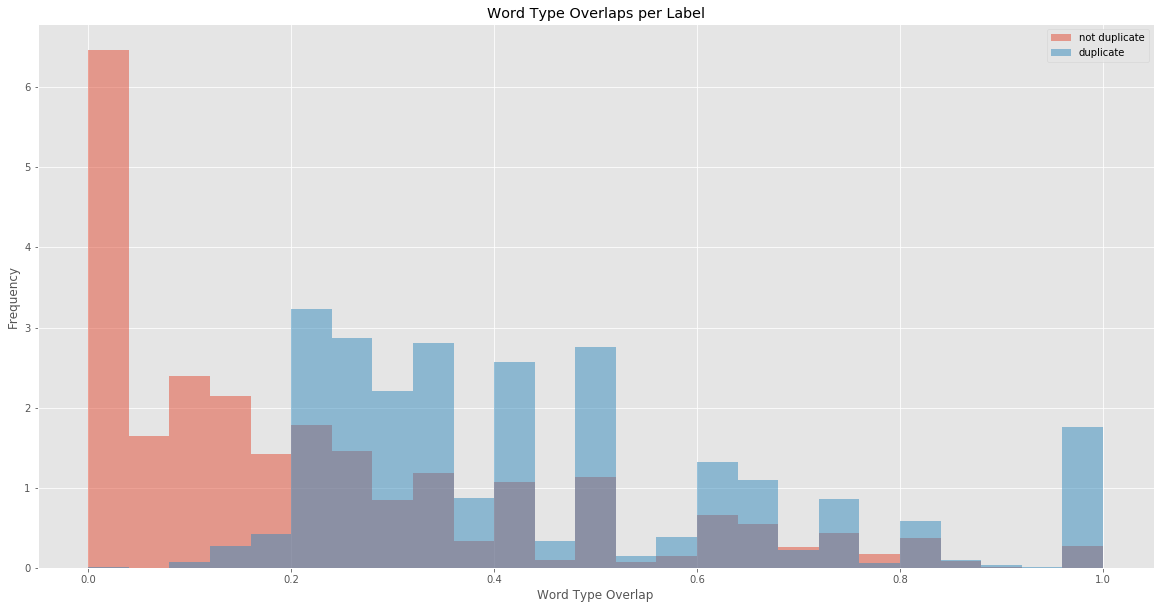

In [163]:
plt.figure()
plt.hist(word_overlaps[train_df.loc[X_train.index]['is_duplicate'] == 0], bins=25, normed=True, label='not duplicate', alpha=.5)
plt.hist(word_overlaps[train_df.loc[X_train.index]['is_duplicate'] == 1], bins=25, normed=True, label='duplicate', alpha=.5)
plt.title('Word Type Overlaps per Label')
plt.xlabel('Word Type Overlap')
plt.ylabel('Frequency')
plt.legend()

/Users/nahiyanmalik/anaconda/envs/mlp3/lib/python3.6/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  
/Users/nahiyanmalik/anaconda/envs/mlp3/lib/python3.6/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  This is separate from the ipykernel package so we can avoid doing imports until


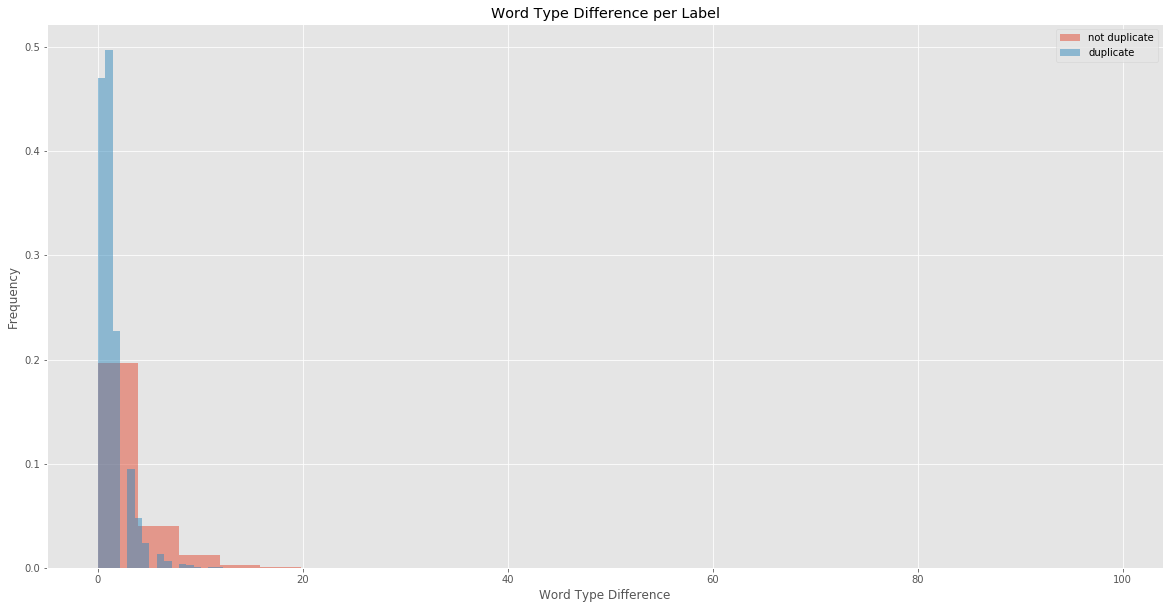

In [164]:
plt.figure()
plt.hist(word_diffs[train_df.loc[X_train.index]['is_duplicate'] == 0], bins=25, normed=True, label='not duplicate', alpha=.5)
plt.hist(word_diffs[train_df.loc[X_train.index]['is_duplicate'] == 1], bins=25, normed=True, label='duplicate', alpha=.5)
plt.title('Word Type Difference per Label')
plt.xlabel('Word Type Difference')
plt.ylabel('Frequency')
plt.legend()

as can be seen from above, the overlap of words types and the differences in types do a good job in separating the labels.

higher word type overlaps indicate a higher probability of a duplicate question. a lower word type count difference has a higher probability of being a duplicate question. this is a good confirmation of word similarity being a good indicator of word similarity playing a large role in paraprhase detection.

there are many ways of computing features for relatedness. the three in focus here are the following:

https://www.researchgate.net/publication/228560462_A_Metric_for_Paraphrase_Detection
euclidean distances

https://arxiv.org/pdf/1805.11611.pdf
edit distance

https://ieeexplore.ieee.org/document/8404391
word embedding

there is also a focus placed on each feature being independent of the question. that is, intead of two length features for questions 1 and 2, a single difference feature encompasses the difference. By reducing the number of features to convey the same information, the goal is greater generalization. https://pdfs.semanticscholar.org/d178/b2e01eaf67e81bdf9406643b701be709f285.pdf employs this strategy.